# Optimizing for Eigenfluids Initial Parameters
## Given final velocity field only

In this optimization scenario, given a final velocity field $v_{target}: [0,\pi]\times[0,\pi] \to \mathbb{R}^2$, we are looking for initial base coefficients $\omega_0$, such that after time $t$, the velocity field reconstructed from the resulting coefficients $\omega_t$ will be exactly $v_{target}$, i.e.:

$$
\arg\min_{\omega} \Big|\text{reconstruct}(\mathcal{P}^{t}(\omega)) - v_{target} \Big|_2^2,
$$

where $\mathcal{P}^t(\omega) = \underbrace{\mathcal{P} \circ \mathcal{P} \dots \circ \mathcal{P}(\omega)}_{t \text{ times}}$ is the physical simulation of base coefficients $\omega$ (in the reduced dimension) $t$ times.

In [1]:
from phi.torch.flow import *
import matplotlib.pyplot as plt

from src.eigenfluid import Eigenfluid

# Helper functions for visualization
from src.visu import *

import time

In [2]:
# Number of basis fields
N = 4**2 
# Domain sizes
DOMAIN = Box(x=math.PI, y=math.PI)
SAMPLING_SIZE = 32

start_time = time.time()
eigenfluid = Eigenfluid(N, DOMAIN, SAMPLING_SIZE)
end_time = time.time()
print("Eigenfluid initialized in {} seconds".format(end_time-start_time))

Eigenfluid initialized in 9.570346117019653 seconds


# Reference Simulations

In [3]:
velocity = eigenfluid.reconstruct_velocity()

trajectory_v = [velocity]
trajectory_curl = [field.curl(velocity)]

#Increase this for harder scenarios
STEPS = 100
DT = 0.2

w_0 = eigenfluid.w

start_time = time.time()
for i in range(STEPS):
    # For grid-based simulation:
    #velocity = advect.semi_lagrangian(velocity, velocity, dt=DT)
    #velocity, _ = fluid.make_incompressible(velocity)
    eigenfluid.w = eigenfluid.step_w_euler(eigenfluid.w, DT)
    
    curr_vel = eigenfluid.reconstruct_velocity()
    trajectory_v.append(curr_vel)
    trajectory_curl.append(field.curl(curr_vel))
end_time = time.time()
print("Simulation finished in {} seconds".format(end_time-start_time))

trajectory_v_ref = math.stack(trajectory_v, batch('time'))
trajectory_curl_ref = math.stack(trajectory_curl, batch('time'))

v_target = eigenfluid.reconstruct_velocity()

Simulation finished in 7.035056829452515 seconds


# Gradients from Eigenfluid simulation

In [4]:
def loss_function(w):
    eigenfluid.w = w
    #velocities = [eigenfluid.reconstruct_velocity()]
    for t in range(STEPS):
        eigenfluid.w = eigenfluid.step_w_euler(eigenfluid.w, DT)
        #velocities.append(eigenfluid.reconstruct_velocity())
    loss = field.l2_loss(eigenfluid.reconstruct_velocity() - v_target)
    return loss#, velocities

gradient_function = math.gradient(loss_function)

loss, grad = gradient_function(w_0)
print("This loss should be zero: {}".format(loss))

This loss should be zero: 0.0


# Optimize for Unknown initial w
Now we would like to find an initial w vector such that it lines up with the target simulation after STEPS number of iterations.

In [105]:
# Initialize w to some value for optimization (random or 0)
#w_init = math.zeros_like(eigenfluid.w)
w_init = math.random_normal(eigenfluid.w.shape)

# first gradient
loss, grad = gradient_function(w_init)
print("Initial Loss of Optimization: {}".format(loss))

Initial Loss of Optimization: 319.81757


## Optimization

In [186]:
w_best = w_optim

In [182]:
# LR = 0.001
LR = 0.00005

#w_optim = w_init
#grads = [grad[-1]]
for optim_step in range(200):
    loss, grad = gradient_function(w_optim)
    if optim_step%5 == 0 or optim_step < 5:
        print("Optimization step %d, loss: %f" % (optim_step, loss))
    grads.append( grad[0] )
    
    w_optim = w_optim - LR * grads[-1]

Optimization step 0, loss: 0.126387
Optimization step 1, loss: 0.126281
Optimization step 2, loss: 0.126175
Optimization step 3, loss: 0.126070
Optimization step 4, loss: 0.125964
Optimization step 5, loss: 0.125859
Optimization step 10, loss: 0.125333
Optimization step 15, loss: 0.124810


KeyboardInterrupt: 

<Figure size 864x360 with 2 Axes>

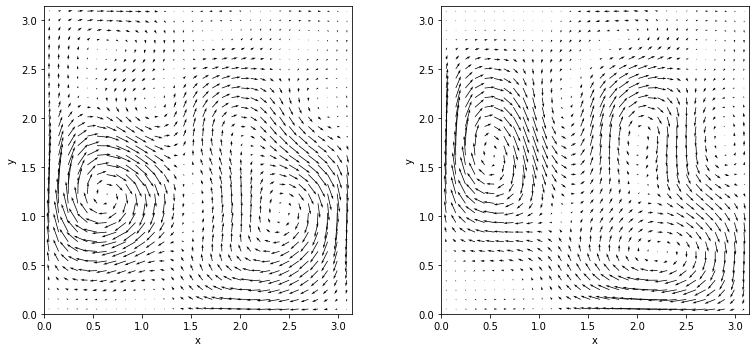

In [183]:
#plot({"Target Velocity": v_target, "Optimized Velocity": eigenfluid.reconstruct_velocity()})
plot([v_target, eigenfluid.reconstruct_velocity()])

In [184]:
list16 = [i for i in range(1,17)]

<BarContainer object of 16 artists>

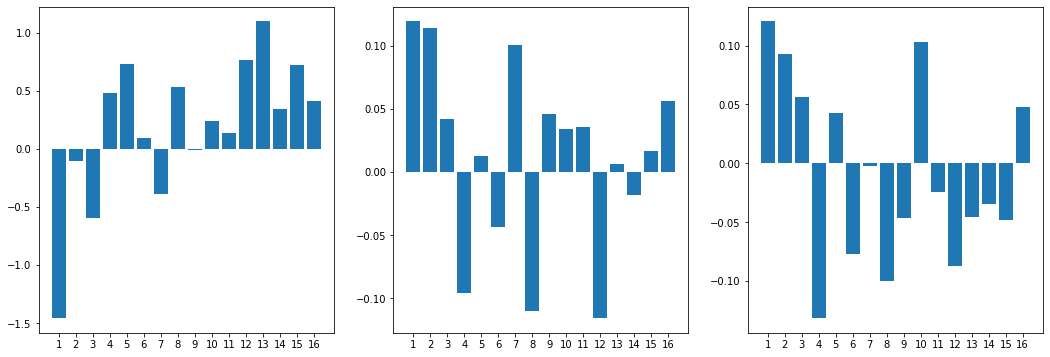

In [185]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))#, constrained_layout=True)


#axs[0].set_title("Randomly initialized coefficients")
axs[0].bar(list16, w_init.numpy(), tick_label=list16)

#axs[1].set_title("Optimized coefficients")
axs[1].bar(list16, w_optim.numpy(), tick_label=list16)

#axs[2].set_title("Target coefficients\n(Unknown during optimization)")
axs[2].bar(list16, w_0.numpy(), tick_label=list16)